# Planetary gravity

The aim of this lecture and practical is to investigate  methods for calculating the gravitational 
field of realistic planetary models using **numerical integration** along with  **spherical harmonic** transformations. In particular, we will focus on the relationship between gravity and surface topography
on Mars.



# Numerical integration

Let's consider  the generic integral
\begin{equation}
I = \int_{a}^{b} f(x) \, \mathrm{d} x. 
\end{equation}
Methods for numerically evaluating such integrals are known as **quadrature rules**, with each approximating
the integral by a finite sum
\begin{equation}
I \approx \sum_{i=0}^{n-1} f(x_{i}) \, w_{i}, 
\end{equation}
where the $x_{0},\dots,x_{n-1}$ are known as **quadrature points** and the $w_{0},\dots,w_{n-1}$ are **quadrature weights**. Different schemes are distinguished by the manner in which these points and weights are chosen. 


Perhaps the simplest quadrature scheme is the **rectangle rule** which is motivated by  definition of an integral as a limit of a sum. The basic idea is most readily understood graphically as is shown below:

![figures/int.png](figures/int.png "Title")

Here the integration points sub-divide the interval $[a,b]$ in increasing order, though they need not be equally spaced. The $i$th integration weight is chosen such that the corresponding term within the sum gives the area of the rectangle with height $f(x_{i})$ and width $x_{i+1}-x_{i}$, and hence 
\begin{equation}
w_{i} = x_{i+1}-x_{i}.
\end{equation}
As the number of subdivisions is increased, the approximating sum tends to the desired integral precisely because this is how integrals are defined!



A simple code implementing this method is shown below and used to evaluate the integral
\begin{equation}
I = \int_{0}^{\pi} \sin \theta \, \mathrm{d} \theta, 
\end{equation}
using the rectangle rule. The exact value of the integral is 2, as can be readily checked. This allows
us to determine the error on the method for a given number of quadrature points.

numerical value =  1.9998355038874454 , relative error =   8.224805627732312e-05


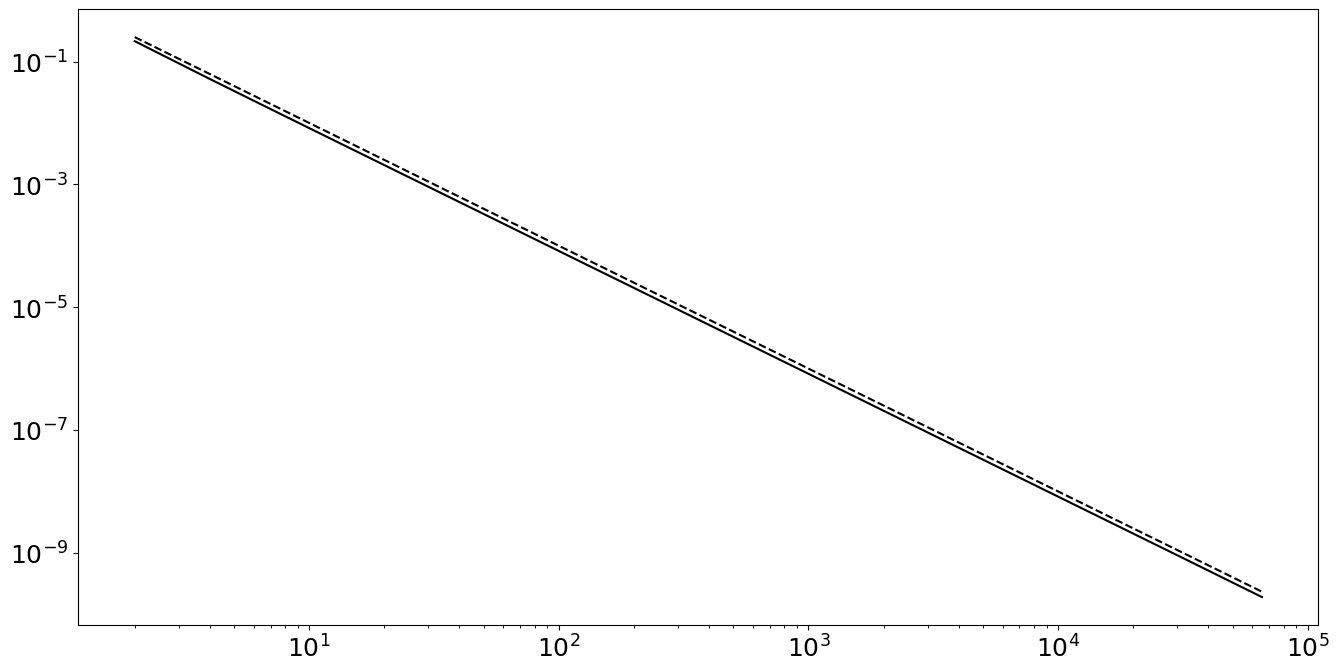

In [1]:
%load_ext autoreload
%autoreload 2

# import libraries                                  
import numpy as np       
import matplotlib.pyplot as plt
from numpy import pi as pi      

# set some plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

# simple function to implement the rectangle rule
def rectangle_integrator(n,a,b,fun):
    dx = (b-a)/n
    x = a
    I = 0.
    for i in range(n):
        I += fun(x)*dx
        x += dx
    return I
    
# apply to sin(x) over 0 to pi
n = 100
I = rectangle_integrator(n,0,pi,np.sin)
print('numerical value = ',I, ', relative error =  ',np.abs(I-2)/2)


# plot the relative error as a function of the number of quadrature points
# on a log-log scale. Also shown is the theoretical error scaling 1/n**2
m = 16
er = np.zeros(m)
nn = np.zeros(m)
et = np.zeros(m)
n = 2
for i in range(m):
    nn[i] = n
    er[i] = np.abs(rectangle_integrator(n,0,pi,np.sin)-2)/2
    et[i] = 1/n**2
    n *= 2

plt.loglog(nn,er,'k')
plt.loglog(nn,et,'k--')
plt.show()

The rectangle rule is very simple and it can sometimes be useful. Often, however, it is worth using more complicated quadrature schemes. Here there can be an added cost in terms understanding and implementing the scheme, but they result in methods that gives better results for the same computational cost. Indeed, for the most part we can use pre-built schemes, and hence there is no need to understand all the technical details ourselves.

A powerful set of quadrature schemes are those based on the theory of orthogonal polynomials. We will not discuss in any detail how or why these work, but simply illustrate one such method in practice. The 
**Gauss-Legendre quadrature** scheme is used for integrals of the form
\begin{equation}
I = \int_{-1}^{1}f(x) \,\mathrm{d} x, 
\end{equation}
but it can be readily applied over different intervals by performing a suitable change of variables. The 
code below applies this method to again evaluate the integral of $\sin x$ over $[0,\pi]$, with the necessary points and weights being obtained using a scipy function. 

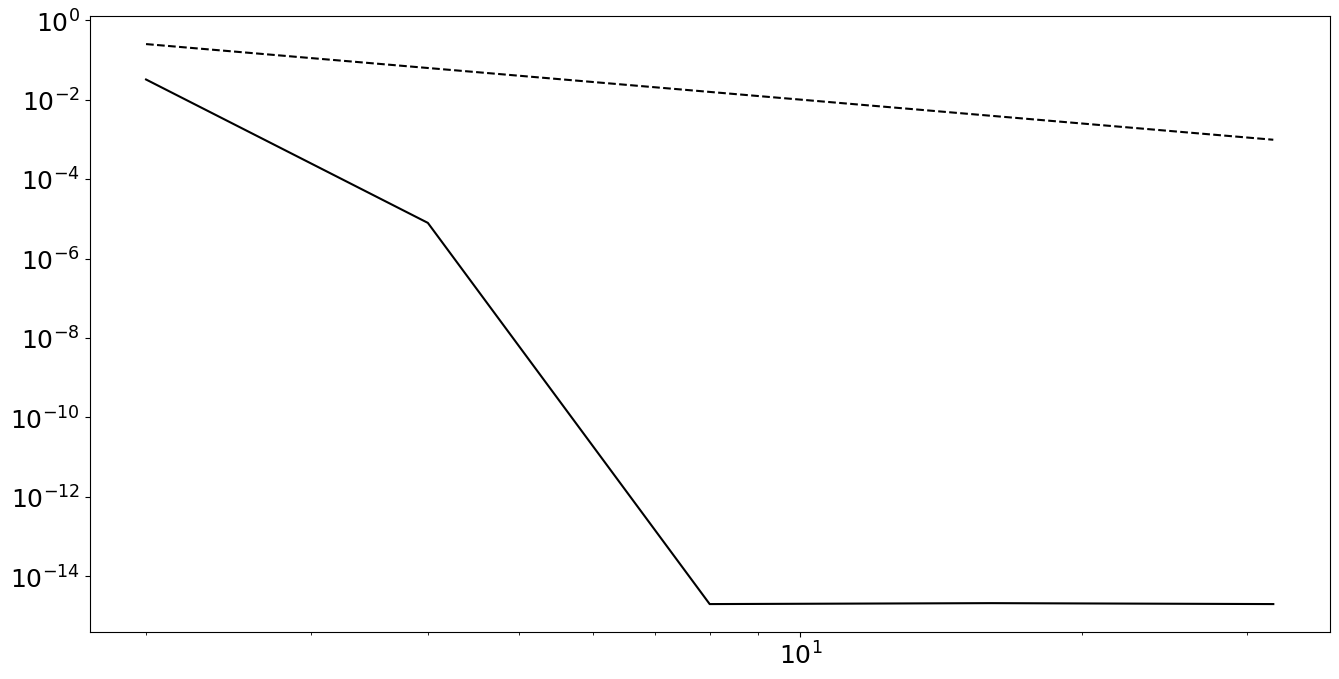

In [2]:
# a function to implement Gauss-Legendre quadrature
def Gauss_Legendre_integrator(n,a,b,fun):
    from scipy.special import roots_legendre
    # get the points and weights over [-1,1]
    x,w = roots_legendre(n)
    # transform to be defined over [a,b] using
    # the mapping y = a + 0.5*(b-a)*(x+1)
    x = a + 0.5*(b-a)*(x+1.)
    w = 0.5*(b-a)*w
    return np.sum(fun(x)*w)
    

# plot the relative error as a function of the number of quadrature points
# on a log-log scale. Also shown is the theoretical error scaling 1/n**2
# from the rectangle rule
m = 5
er = np.zeros(m)
nn = np.zeros(m)
et = np.zeros(m)
n = 2
for i in range(m):
    nn[i] = n
    er[i] = np.abs(Gauss_Legendre_integrator(n,0,pi,np.sin)-2)/2
    et[i] = 1/n**2
    n *= 2

plt.loglog(nn,er,'k')
plt.loglog(nn,et,'k--')
plt.show()



Here we see a very dramatic reduction of the error using the same number of quadrature points, and hence function evaluations, with the Gauss-Legendre method being essentially exact when using only 8 points! In fact, it can be shown that a GL-quadrature with $n$ points gives exact results (up to floating-point rounding errors) for any polynomial function of order less than or equal to $2n-1$.

# Spherical polar co-ordinates

The Earth and most other planets are close to being **spherically symmetric**, which is to say that their shape is that of a sphere, while density varies only with radius. For this reason it is very useful to work with spherical polar co-ordinates $(r,\theta,\phi)$ which are related to standard Cartesian ones by:
\begin{align}
x &= r \sin \theta \cos \phi, \\
y &= r \sin \theta \sin \phi, \\
z &= r \cos \theta.
\end{align}
We note that the **colatitude** $\theta$ and **longitude** $\phi$ are defined in the intervals
$[0,\pi]$ and $[0,2\pi]$, respectively.

The geometric interpretation of these coordinates can be seen in the following figure:

![figures/Sphpol.png](figures/Sphpol.png "Title")

In Cartesian co-ordinates the Laplacian operator is given by
\begin{equation}
\nabla^{2} = \frac{\partial^{2}}{\partial x^{2}} + \frac{\partial^{2}}{\partial y^{2}} + \frac{\partial^{2}}{\partial z^{2}}. 
\end{equation}
Transforming this expression to spherical polar co-ordinates is a tedious but routine exercise and leads to 
\begin{equation}
\nabla^{2} = \frac{1}{r^{2}}\frac{\partial}{\partial r}\left(r^{2}\frac{\partial}{\partial r}\,
\right) + \frac{1}{r^{2}\sin\theta}\frac{\partial}{\partial \theta}\left(
\sin\theta \frac{\partial }{\partial \theta}\,
\right) + \frac{1}{r^{2}\sin^{2}\theta}\frac{\partial^{2}}{\partial \phi^{2}}.
\end{equation}
It will be convenient to define the **Laplace-Beltrami operator** as
\begin{equation}
\nabla^{2}_{1} = \frac{1}{\sin\theta}\frac{\partial}{\partial \theta}\left(
\sin\theta \frac{\partial }{\partial \theta}\,
\right) + \frac{1}{\sin^{2}\theta}\frac{\partial^{2}}{\partial \phi^{2}}, 
\end{equation}
and hence express the Laplacian in the form
\begin{equation}
\nabla^{2} = \frac{1}{r^{2}}\frac{\partial}{\partial r}\left(r^{2}\frac{\partial}{\partial r}\,
\right) + \frac{1}{r^{2}} \nabla^{2}_{1}. 
\end{equation}
The Laplace-Beltrami operator can be seen as the Laplacian defined on the surface of a unit sphere, 
and plays an important role within the definition of spherical harmonics.

We also note that relative to spherical polar co-ordinates the volume element $\mathrm{d} V$ takes the form
\begin{equation}
\mathrm{d} V = r^{2} \sin\theta \, \mathrm{d}r \, \mathrm{d}\theta \,\mathrm{d}\phi, 
\end{equation}
while the surface element on a sphere of radius $r$ is
\begin{equation}
\mathrm{d} S = r^{2} \sin\theta \, \mathrm{d}\theta \,\mathrm{d}\phi.
\end{equation}

**You should be familiar with the definition of spherical polar co-ordinates. But you do not need to memorise any of the the formula nor be able to derive them.**

# Spherical harmonics and expansions


The spherical harmonic functions are defined through solution of the eigenvalue problem
\begin{equation}
\nabla_{1}^{2} Y_{lm} = -l(l+1)Y_{lm}.
\end{equation}
Each spherical harmonic, $Y_{lm}$, is characterised by two **integers**, its **degree** $l$ and **order** $m$. The degree
takes only non-negative values, while for each fixed degree $l$ there are $2l+1$ linearly independent spherical harmonics  with the order $-l \le m \le l$.

There are different normalisation conventions for spherical harmonics, but the one we will use is:
\begin{equation}
    \int_{\mathbb{S}^{2}} Y_{lm}\,Y_{l'm'} \,\mathrm{d} S = \delta_{ll'}\delta_{mm'}, 
\end{equation}
where $\delta_{ij}$ is the Kronecker delta symbol that equals $1$
if $i = j$ and vanishes otherwise. Such spherically harmonics are said to be **orthonormalised**.
 We will also make use of **real-valued** spherical harmonics
as this is most convenient for most geophysical applications.

A key property of spherical harmonics is that they can be used to expand an arbitrary function
on the unit sphere. For example, if $f:\mathbb{S}^{2} \rightarrow \mathbb{R}$ is such a function
we can write
\begin{equation}
f(\theta,\phi) = \sum_{l=0}^{\infty}\sum_{m=-l}^{l} f_{lm}\, Y_{lm}(\theta,\phi),
\end{equation}
for suitable expansion coefficients, $f_{lm}$. In fact, using the orthogonality property
of the spherical harmonics, it is clear that
\begin{equation}
f_{lm} = \int_{\mathbb{S}^{2}} f\, Y_{lm} \, \mathrm{d} S = \int_{0}^{2\pi} \int_{0}^{\pi}
f(\theta,\phi) \, Y_{lm}(\theta,\phi)\, \sin \theta \,\mathrm{d} \theta \, \mathrm{d} \phi.
\end{equation}
It follows that given a function, $f$, we can obtain its spherical harmonic expansion coefficients
by performing suitable double integrals. Conversely, the function can be recovered from these 
coefficients by summing the appropriate series.







## Working with PYSHTOOLS

To work with spherical harmonics in python, it is useful to import the module pyshtools. This is contains a range of useful functions to work with spherical harmonics, including fast spherical harmonic transformations that we discuss further below. It should be added that the core of pyshtools is not written in python but calls underlying Fortran routines. This allows the methods to be very substantially faster, with the situation being similar to a lot of more common python modules such as numpy where the core linear algebra routines are again written in lower-level languages.

As a first example, we can use this module to visualise spherical harmonics of different degrees and orders. In doing this some of the syntax and functionality of this library can be seen. 

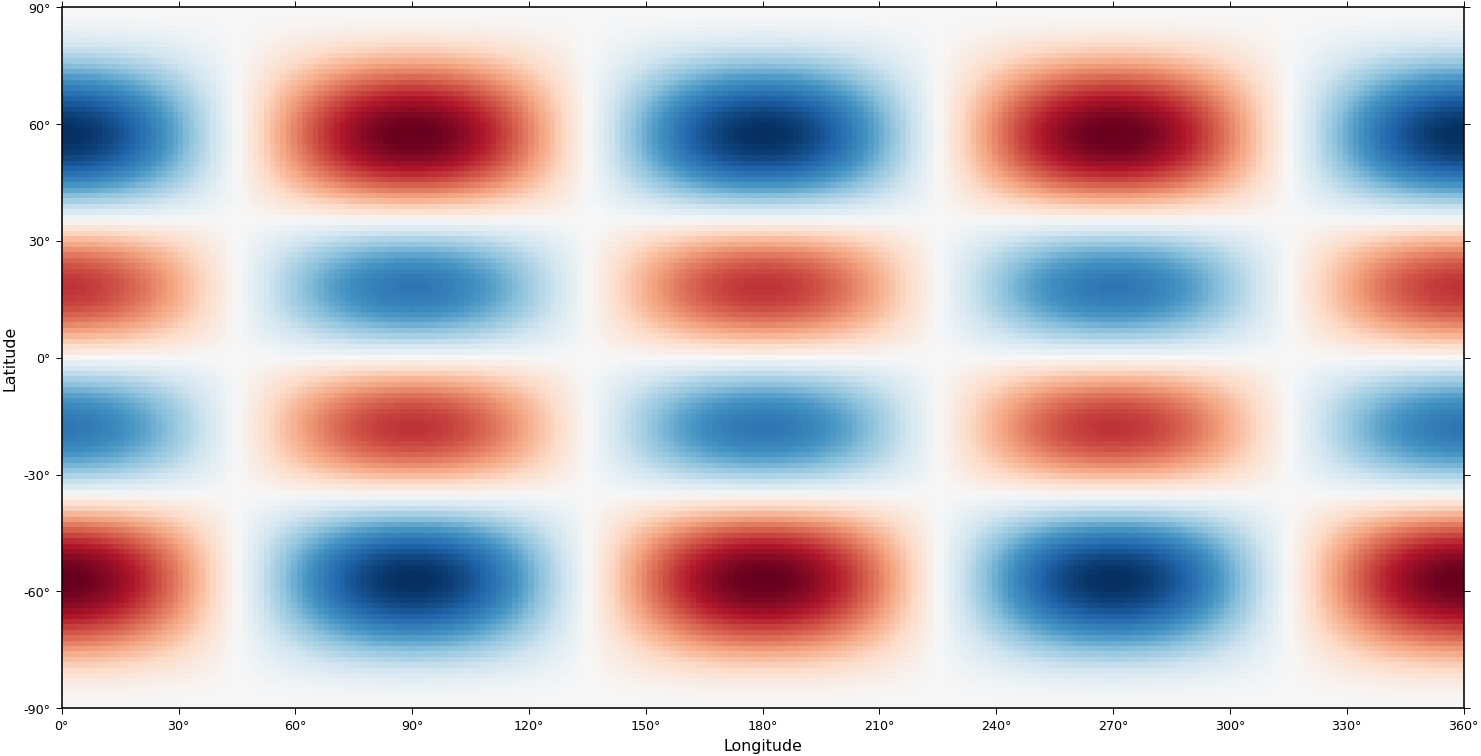

In [3]:
# import the library
import pyshtools as pysh

# set the plot size
pysh.utils.figstyle(rel_width=1.75)

# make a spatial grid suitable for resolving 
# functions with power up to a given maximum degree
L = 64
fun = pysh.SHGrid.from_zeros(lmax = L)

# set the degree and order for plotting
l = 5
m = 2

# loop over the latitudes and longitudes within the grid
ilat = 0
for lat in fun.lats():
    # note that we need co-latitude for the function call below and that
    # angular arguments are in degrees by default
    clat = 90-lat 
    ilon = 0
    for lon in fun.lons():
        # Note the optional argument asking for them to be fully normalised. 
        fun.data[ilat,ilon] = pysh.expand.spharm_lm(l,m,clat,lon,normalization = 'ortho')
        ilon += 1
    ilat += 1

# plot the function
fig, ax = fun.plot(show = False,cmap='RdBu')


By plotting the spherical harmonics for a range of $l$ and $m$ values, we can make the following qualitative conclusions:

 - The degree controls the dominant wavelength of the spherical harmonic, with higher $l$ meaning shorter wavelength. In fact, the following approximate relation can be established:
 \begin{equation}
 \lambda = \frac{2\pi}{l+\frac{1}{2}},
 \end{equation}
 for the non-dimensional wavelength associated with a spherical harmonic of degree $l$.
 - For a fixed $l$, the order $m$ is related to the longitudinal wavelength. 
 
The key point here is that is that if we know the length-scales contained in a given function, we can determine an appropriate **truncation degree** $L$ to use in spherical harmonic expansions. 

## Fast spherical harmonic expansions

We have seen that the $(l,m)$th spherical harmonic expansion coefficient of a function, $f$, is given by
\begin{equation}
f_{lm}  = \int_{0}^{2\pi} \int_{0}^{\pi}
f(\theta,\phi) \, Y_{lm}(\theta,\phi)\, \sin \theta \,\mathrm{d} \theta \, \mathrm{d} \phi.
\end{equation}
Here each of the integrals can be performed using a suitable quadrature scheme. Within a spatial 
discretisation of the function based on a grid with truncation degree $L$, the number of points in both ]
latitude and longitude are proportional to $L$ (the precise value depending on the details of the 
algorithms we will not consider). It is, therefore, natural to use quadrature schemes with the 
same numbers of points, and hence the naive cost of performing the double integral scales like 
$L^{2}$. If we wish to obtain all the expansion coefficients up to the trunction degree, then the 
total number of such integrals is equal to the following summation 
\begin{equation}
\sum_{l=0}^{L} (2l+1) = (L+1)^2.
\end{equation}
It follows that the cost of a spherical harmonic transform using this method scales like $L^{4}$. Such an increase of cost with truncation degree is quite high, and so this is a potentially costly method. 

Happily, there is a better way of proceeding. The idea, in outline, is to recognise that the longitudinal dependence of spherical harmonics of order $m$ goes like $\sin m \phi$ or $\cos m \phi$. As a result, 
the longitudinal integrals that are required look much like those involved in Fourier transforms. From this it can be shown that the **Fast Fourier Transform** (FFT) method can be applied to simplify the calculations. The end result is a cost that scales like $L^{3} \mathrm{log} L$. While this may not seem like a hugh difference, it really does help in practice.  

For this course you do not need to know very great details of the fast spherical harmonic transformations. What you need to know is that they are based on numerical quadrature schemes and that they are made more efficient by the application of the FFT algorthim. Moreover, the spatial discretisation scheme that is truncated at degree $L$ is such that the transformations will be exact (up to numerical rounding errors) so long as a function is bandlimited below degree $L$, this meaning that all its spherical harmonic coefficients
for degrees $l > L$ vanish. With real functions this condition may not hold exactly, but the method will be sufficient so long as the coefficients beyond the truncation degree are sufficiently small. 

Within the following code, we show how these transformations can be applied within pyshtools. First we load in a data set for surface topography, $T$, on Mars. Having done this we obtain the spherical harmonic expansion coefficients, $T_{lm}$, and then plot the power, $P_{l}$, as a function of degree defined as
\begin{equation}
P_{l} = \sum_{m=-l}^{l} T_{lm}^{2}.
\end{equation}
This plot can be understood as quantifying the contributions to the topography at different spatial 
wavelengths.



In [ ]:
# load in the data
import mars_topo as MT
T = MT.Topo()

# maximum degree used in the data
L = T.lmax

# make a plot
fig,ax = T.plot(show=False,colorbar = 'right',cmap='RdBu')

# obtain the expansion coefficients
T_lm = T.expand(normalization = 'ortho')

# compute the power spectrum
P = np.zeros(L+1)
for l in range(L+1):
    P[l] += np.linalg.norm(T_lm.coeffs[:,l,:])

plt.figure()
plt.loglog(P)
plt.xlabel('spherical harmonic degree')
plt.ylabel('topographic power')
plt.show()
    

Here it is worth making a comment about how spherical harmonic coefficients are stored within pyshtools. 
Having created a coefficient object such as T_lm above, we can access the coefficients within
the sub-object T_lm.coeffs which is has shape (2,L+1,L+1). If $m \ge 0$, then the value of $T_{lm}$
is stored within T_{lm}.coeffs[0,l,m], while when $m < 0$, we look in  T_{lm}.coeffs[1,l,-m]. Note that
elements of the coefficient array that are not required, such as coeffs[1,l,0], are all set equal to zero.

Having transformed the function to obtain coefficients, it is a simple matter to transform back:

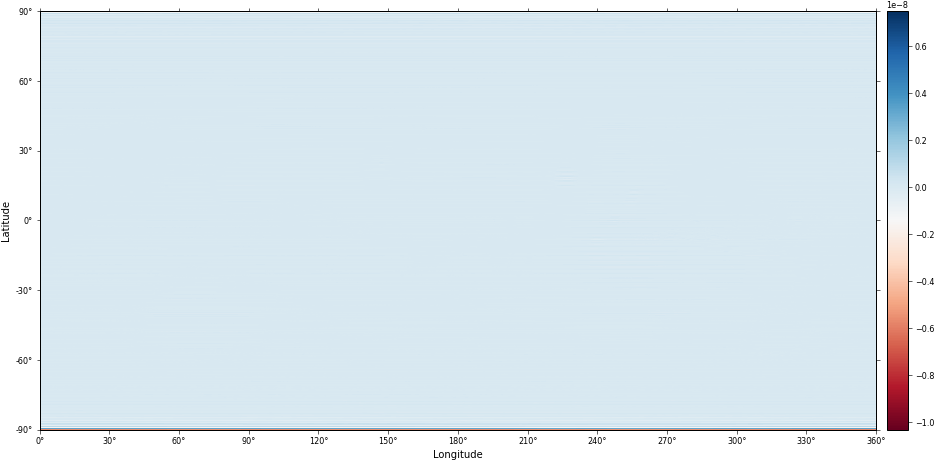

In [5]:
# transform from coeffcients to the function
T_rec = T_lm.expand()

# plot the difference between the original and recovered
T_diff = T-T_rec
fig,ax = T_diff.plot(show = False,cmap = 'RdBu',colorbar = 'right')

# Calculating the gravity anomaly due to the surface topography

Having assembled the basic tools required, we can now see how spherical harmonic methods can be used to solve a realistic geophysical problem: how the gravity potential associated with this surface topography can be calculated. To do this we need to solve Laplace's equation
\begin{equation}
\nabla^{2}\varphi = 0, \quad \mathbf{x} \in \mathbb{R}^{3}, 
\end{equation}
subject to the jump conditions
\begin{equation}
    [\varphi]_{-}^{+} = 0, \quad [\hat{\mathbf{n}}\cdot \nabla \varphi + 4\pi G \rho T]_{-}^{+} = 0, 
\end{equation}
across the planet's spherical reference surface $r = b$. Here $\varphi$ is the perturbation to the gravitational potential, $G$ the gravitational constant, $\rho$ the density within the planet, and $\hat{\mathbf{n}}$ the unit normal vector to the reference surface.  It is worth noting that this equation is not exact, but accurate to first order in the dimensionless quantity $T/b$. For most planetary application this quantity is much less than one, and hence the approximate theory works well.

The key idea in solving this problem is to expand the gravitational potential in spherical harmonics
\begin{equation}
\varphi(r,\theta,\phi) = \sum_{lm} \varphi_{lm}(r) \,Y_{lm}(\theta,\phi), 
\end{equation}
where we note that the radial dependence of the field is reflected through the expansion coefficients being 
functions of $r$. Using the spherical polar expression for the Laplacian
\begin{equation}
\nabla^{2} = \frac{1}{r^{2}}\frac{\partial}{\partial r}\left(r^{2}\frac{\partial}{\partial r}\,
\right) + \frac{1}{r^{2}} \nabla^{2}_{1}. 
\end{equation}
along with the properties of the spherical harmonics it can be shown that the problem reduces to solution of
\begin{equation}
 \frac{1}{r^{2}}\frac{\mathrm{d}}{ \mathrm{d} r}\left(r^{2}
\frac{\mathrm{d} \varphi_{lm}}{\mathrm{d} r}\,
\right) - \frac{l(l+1)}{r^{2}} \varphi_{lm}  = 0, 
\end{equation}
for each degree $l$ and order $m$, with these  equations being subject at $r = b$ to the 
jump conditions
\begin{equation}
[\varphi_{lm}]_{-}^{+} = 0, \quad \left[
\frac{\mathrm{d} \varphi_{lm}}{\mathrm{d} r} + 4\pi G \rho T_{lm}
\right]_{-}^{+} = 0, 
\end{equation}
where $T_{lm}$ are the  expansion coefficients on the topography. It is possible to solve these
ordinary differential equations in closed-form to obtain
\begin{equation}
    \varphi_{lm}(r) =  \frac{ 4\pi G [\rho]_{-}^{+} b\, T_{lm}}{2l+1} \left\{
    \begin{array}{ll}
     \left(
    \frac{r}{b}
    \right)^{l} & 0\le r \le b \\
     \left(
    \frac{b}{r}
    \right)^{l+1} & r \ge b
    \end{array}
    \right.. 
\end{equation}
When visualising gravitational potential perturbations on the reference surface $r = b$, it is common to convert them into the associated **geoid height anomaly** as defined by
\begin{equation}
h(\theta,\phi) = - \frac{\varphi(b,\theta,\phi)}{g}. 
\end{equation}
It is readily seen that this quantity does have the units of length. In the next lecture we will see the motivation for this definition.


From a computational view these results can be implmented in a very simple manner. Indeed, 
the potential is related to the topography through a simple degree-dependent scaling, and this can be 
implemented as follows:

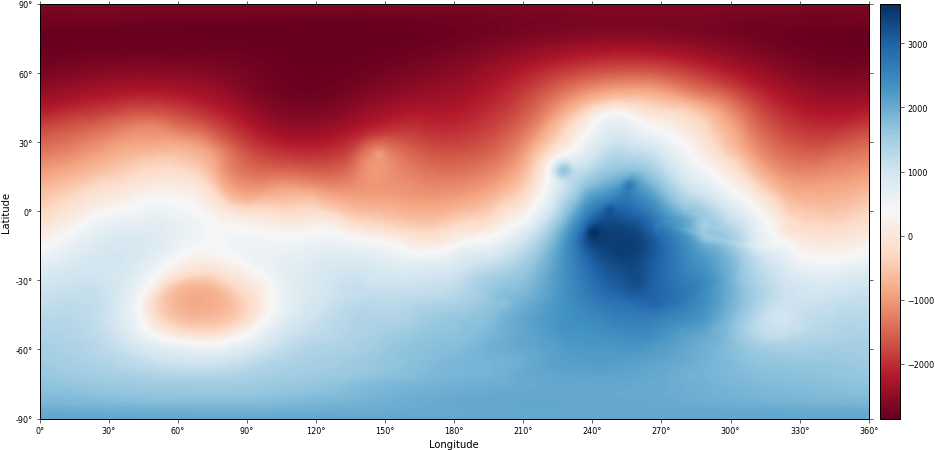

In [6]:
# set the gravitational constant
G = 6.67408e-11

# function to compute the gravity anomaly due to topography
# T on the surface r = a associated with a density jump Drho. 
# The result is the potential field at an external radius r >= a.
def potential_anomaly(T,b,Drho,r):
    phi_lm = T.expand(normalization = 'ortho')
    for l in range(T.lmax+1):
        fac = 4*pi*G*Drho*b/(2*l+1)
        fac = fac*(b/r)**(l+1)
        phi_lm.coeffs[:,l,:] *= fac      
    return phi_lm.expand()

# set parameters for Mars
b   = 3.3895e6
rho = 3.0e3    
g   = 3.711

# compute the response -- note density jump is negative 
# of the surface density as the topography is at the surface
h = (-1/g)*potential_anomaly(T,b,-rho,b)
fig,ax = h.plot(show=False,colorbar='right',cmap='RdBu')

# What you need to know and be able to do

- Understand the purpose of numerical integration and the general form of a quadrature scheme. You should be able to explain the rectangle rule and how it can be implemented, but do not need to know the details of more complicated schemes. 

- Be familiar with the definitions of spherical polar co-ordinates, though you do not need to memorise the associated formulae. 

- Know that spherical harmonics are characterised by their degree and order, and the link between the degree and the typical length-scale. You do not need to memorise any of the formulae related to the definition of spherical harmonics, but might be asked to perform calculations given the required information. 

- Know that a function on the unit sphere can be expanded in spherical harmonics, and how the expansions coefficients can be obtained.

- Describe in *outline* the steps within a fast spherical harmonic transformation.
    
- Given appropriate formula, describe in outline the steps by which a model of topography can be converted into the associated potential or gravity anomaly. You may also   be asked to manipulate such formulae in simple ways so as to obtain physical insight. 

## Practical exercise 1

In many applications the interesting quantity is not the gravitational potential perturbation but the associated **gravity anomaly** as defined by
\begin{equation}
\Delta g = \left.\frac{\partial \varphi}{\partial r}\right|_{r=b+0}. 
\end{equation}
Supposing that we have topography, $T$, on a surface with radius $r = b$ and associated with a density 
jump, $ [\rho]_{-}^{+}$, show that the gravity anomaly, $\Delta g$, has expansion coefficients when $r \ge b$: 
\begin{equation}
    \Delta g_{lm}(r) =  -\frac{ 4\pi (l+1) G [\rho]_{-}^{+}\, T_{lm}}{2l+1} 
     \left(
    \frac{b}{r}
    \right)^{l+2}. 
\end{equation}

Write a function to compute $\Delta g$ and apply it to Mars' surface topography. Compare your result with the familiar Bouber anomaly formula $\Delta g = 2 \pi G \rho T$.


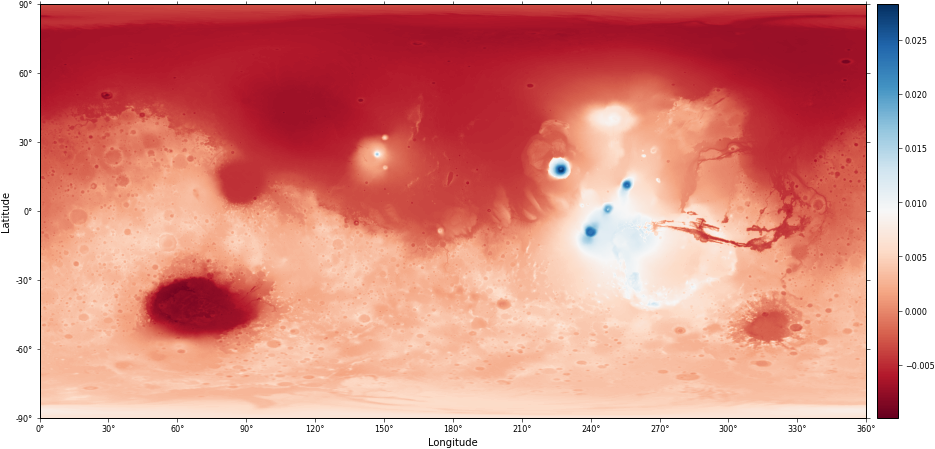

In [7]:
# function to compute the gravity anomaly due to topography
# T on the surface r = a associated with a density jump Drho. 
# The result is the potential field at an external radius r >= b.
def gravity_anomaly(T,b,Drho,r):
    Dg_lm = T.expand(normalization = 'ortho')
    for l in range(T.lmax+1):
        fac = -4*pi*G*Drho*(l+1)/(2*l+1)
        fac = fac*(b/r)**(l+2)
        Dg_lm.coeffs[:,l,:] *= fac      
    return Dg_lm.expand()

# set parameters for Mars
b   = 3.3895e6
rho = 3.0e3    
g   = 3.711

# compute the response at the surface
Dg = gravity_anomaly(T,b,-rho,b)
fig,ax = Dg.plot(show=False,colorbar='right',cmap='RdBu')

Looking at the gravity anomaly, it hopefully occurs that it looks very much like the surface topography! This is not an accident. If we look at our expression for the coefficients in the case that $r = b$, then we have
\begin{equation}
    \Delta g_{lm}(r) =  \frac{ 4\pi (l+1) G \rho\, T_{lm}}{2l+1}.
\end{equation}
For large values of $l$, meaning short wavelengths, we have
\begin{equation}
\frac{l+1}{2l+1} = \frac{1}{2}\frac{1 + \frac{1}{l}}{1+\frac{1}{2l}} \approx \frac{1}{2}, 
\end{equation}
and hence $\Delta g_{lm}(r) \approx 2\pi G \rho T_{lm}$, which implies the well-known Bouger
formula
\begin{equation}
\Delta g = 2\pi G \rho T.
\end{equation}
The code below compares the accurate result above to the result of the Bouger formula, and it can be see that the error is indeed dominantly at long wavelengths.

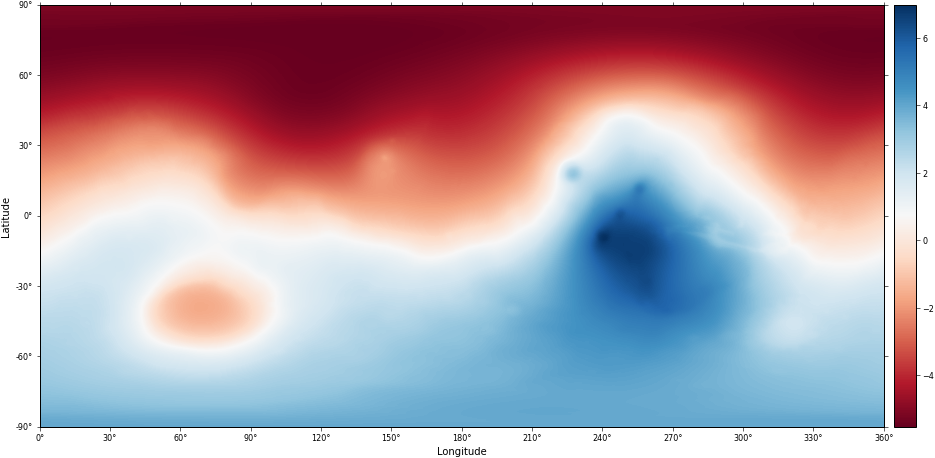

In [8]:
# get maximum value of gravity anomaly
Dg_max = np.max(np.abs(Dg.data))
# compute the percentage error using the Bouger formula
Dg_error = 100*(Dg- 2*pi*G*rho*T)/Dg_max
# plot the result
fig,ax = Dg_error.plot(show=False,colorbar='right',cmap='RdBu')


# Practical exercise 2

The gravity anomaly calculated  in exercise 1 does accurately model the effect of Mars' surface topography. The **observed** gravity anomaly on Mars is, however, quite different due to the presence of crustal roots etc.
To take this into account, we consider a simple crustal model comprising a single layer of uniform density $\rho_{c}$ overlying a mantle of density $\rho_{m}$. The crust has average thickness $H$ but varies laterally due to (i) topography $T$ measured **positive upwards** relative to the mean surface radius $r = b$, and (ii) a crustal root of thinkness $R$ measured **positive downwards** relative to the mean crustal base with radius $r = b-H$. 

Write functions to determine the potential and gravity anomalies given vaules for $T$ and $R$.

Assuming that an isostatic balance holds within the crust, calculate and plot both the geoid height anomaly and the gravity anomaly for Mars. In doing this you can assume the following additional values that are required:
- crustal density for Mars $\rho_{c} = 3000\,\mbox{kg}\,\mbox{m}^{-3}$
- mantle density fro Mars $\rho_{m} = 3300\,\mbox{kg}\,\mbox{m}^{-3}$
- average crustal thickness $H = 30\,\mbox{km}$

You might find it interesting to vary the crustal thickess to see how this changes the results.

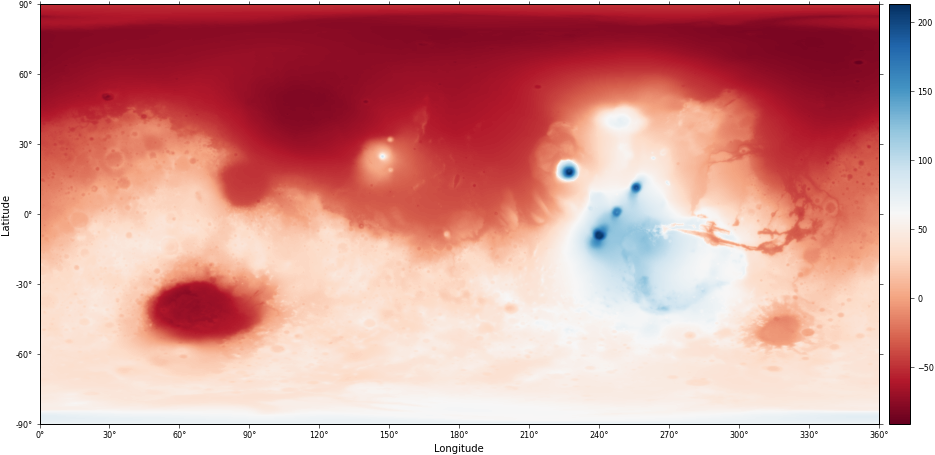

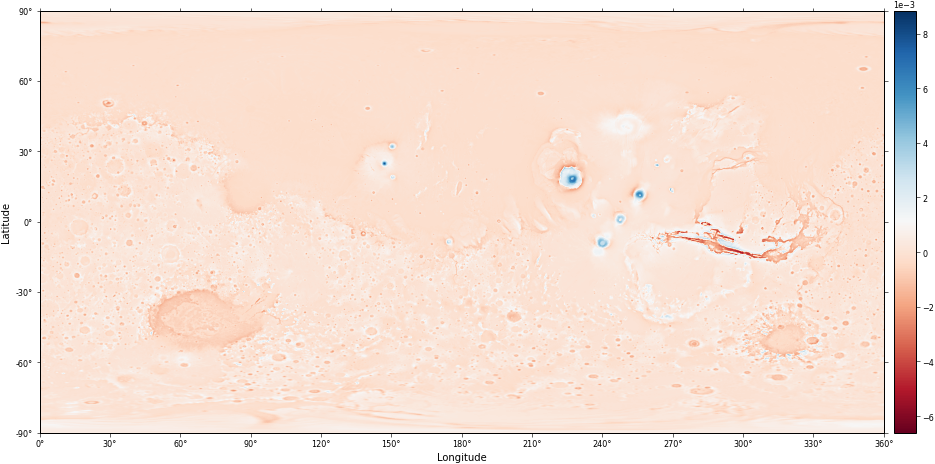

In [9]:
def potential_anomaly_with_crust(T,R,b,H,rhoc,rhom,r):
    phi = potential_anomaly(T,b,-rhoc,r) - potential_anomaly(R,b-H,rhoc-rhom,r)
    return phi

def gravity_anomaly_with_crust(T,R,b,H,rhoc,rhom,r):
    Dg = gravity_anomaly(T,b,-rhoc,r) - gravity_anomaly(R,b-H,rhoc-rhom,r)
    return Dg
    
# set parameters  
rhoc = 3000.                                                    
rhom = 3300.                                                    
H    = 30000. 

# set the root using an isostatic balance
R = (rhoc*T)/(rhom-rhoc)

# get the potential anomaly
h = (-1/g)*potential_anomaly_with_crust(T,R,b,H,rhoc,rhom,b)
fig,ax = h.plot(show=False,colorbar='right',cmap='RdBu')


# now the gravity anomaly
Dg = gravity_anomaly_with_crust(T,R,b,H,rhoc,rhom,b)
fig,ax = Dg.plot(show=False,colorbar='right',cmap='RdBu')